1


I performed data cleaning and exploration by checking for missing values and negative cash flow entries, and ensured that all date and year columns were converted to a consistent format for reliable analysis.

In [3]:
!pip install xlsxwriter


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\KARTHIKA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [33]:
# Load the Excel sheet
df = pd.read_excel(r"C:\Users\KARTHIKA\Documents\Data\Cement_Combined_Cashflow.xlsx", sheet_name="Combined_Cashflow")
output_file = r"C:\Users\KARTHIKA\cement\Cement_Combined_Cashflow_new.xlsx"

In [34]:
# Strip any whitespace from column names
df.columns = [str(col).strip() for col in df.columns]

# Identify year columns (those that are digits like '2012', '2013', etc.)
year_cols = [col for col in df.columns if col.isdigit()]

# Check for missing (NaN) values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Identify numeric columns (likely the year/cashflow columns)
numeric_cols = df.select_dtypes(include='number').columns

# Count of negative values in each numeric column
negative_counts = (df[numeric_cols] < 0).sum()

# Rename string year columns to integers
df.rename(columns={col: int(col) for col in df.columns if isinstance(col, str) and col.isdigit()}, inplace=True)


Missing values in each column:
 Financial_Metric     0
Company              0
2012                12
2013                 4
2014                 4
2015                 4
2016                 4
2017                 0
2018                 0
2019                 0
2020                 0
2021                 0
2023                 0
2024                 0
2022                 8
2025                16
dtype: int64


In [35]:
# Arrange columns: keep 'Financial_Metric' and 'Company' first, then sorted year columns
fixed_columns = ['Financial_Metric', 'Company']
year_columns = sorted([col for col in df.columns if col not in fixed_columns and isinstance(col, int)])
df = df[fixed_columns + year_columns]

In [36]:
# Polynomial interpolation to fill missing 2022 values
if 2022 in year_columns:
    for idx, row in df.iterrows():
        y_values = row[year_columns].astype(float)
        if pd.isna(y_values[2022]):
            known_years = [year for year in year_columns if year != 2022 and not pd.isna(y_values[year])]
            known_values = [y_values[year] for year in known_years]
            if len(known_years) >= 3:  # Minimum needed for 2nd-degree polynomial
                X = np.array(known_years).reshape(-1, 1)
                y = np.array(known_values).reshape(-1, 1)

                poly = PolynomialFeatures(degree=2)
                X_poly = poly.fit_transform(X)

                model = LinearRegression()
                model.fit(X_poly, y)

                pred_2022 = model.predict(poly.transform(np.array([[2022]])))[0, 0]
                df.at[idx, 2022] = pred_2022

print("\nMissing values in 2022 filled using polynomial interpolation.")


Missing values in 2022 filled using polynomial interpolation.


In [37]:
# Final check: Negative cashflow counts
print("\nNegative cashflow indicators:\n", negative_counts)

# Check column names and types
print("\nColumn names after renaming:")
print(df.columns)


Negative cashflow indicators:
 2012     8
2013    15
2014    14
2015    16
2016    14
2017    18
2018    11
2019    13
2020    18
2021    16
2023    18
2024    11
2022    14
2025     9
dtype: int64

Column names after renaming:
Index(['Financial_Metric',          'Company',               2012,
                     2013,               2014,               2015,
                     2016,               2017,               2018,
                     2019,               2020,               2021,
                     2022,               2023,               2024,
                     2025],
      dtype='object')


In [38]:
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name="Combined_Cashflow_new", index=False)
print("✅ All data combined into a single Excel sheet.")

✅ All data combined into a single Excel sheet.


In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Load Excel sheet
df = pd.read_excel(r"C:\Users\KARTHIKA\Documents\Data\Cement_Combined_Cashflow.xlsx", sheet_name="Combined_Cashflow")
output_file = r"C:\Users\KARTHIKA\cement\Cement_Combined_Cashflow_new_1.xlsx"

# Strip whitespace from column names
df.columns = [str(col).strip() for col in df.columns]

# Identify year columns
year_cols = [int(col) for col in df.columns if col.isdigit()]
df.rename(columns={str(col): int(col) for col in year_cols}, inplace=True)

# Reorganize columns
fixed_columns = ['Financial_Metric', 'Company']
df = df[fixed_columns + sorted(year_cols)]

# Fill missing values for any year using 2nd-degree polynomial interpolation
for year in sorted(year_cols):
    for idx, row in df.iterrows():
        y_values = row[year_cols].astype(float)
        if pd.isna(y_values[year]):
            known_years = [y for y in year_cols if y != year and not pd.isna(y_values[y])]
            known_values = [y_values[y] for y in known_years]

            if len(known_years) >= 3:  # At least 3 points for 2nd-degree polynomial
                X = np.array(known_years).reshape(-1, 1)
                y_known = np.array(known_values).reshape(-1, 1)

                poly = PolynomialFeatures(degree=2)
                X_poly = poly.fit_transform(X)

                model = LinearRegression()
                model.fit(X_poly, y_known)

                pred = model.predict(poly.transform(np.array([[year]])))[0, 0]
                df.at[idx, year] = pred

print("✅ Missing values filled using polynomial interpolation.")

# Save to Excel
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    df.to_excel(writer, sheet_name="Combined_Cashflow_new_1", index=False)

print("✅ Cleaned and filled data saved to Excel.")

✅ Missing values filled using polynomial interpolation.
✅ Cleaned and filled data saved to Excel.


 2

This code shows the trend of operating cash flows (OCF) for different companies over the years and helps identify which companies have consistently positive or negative OCF.

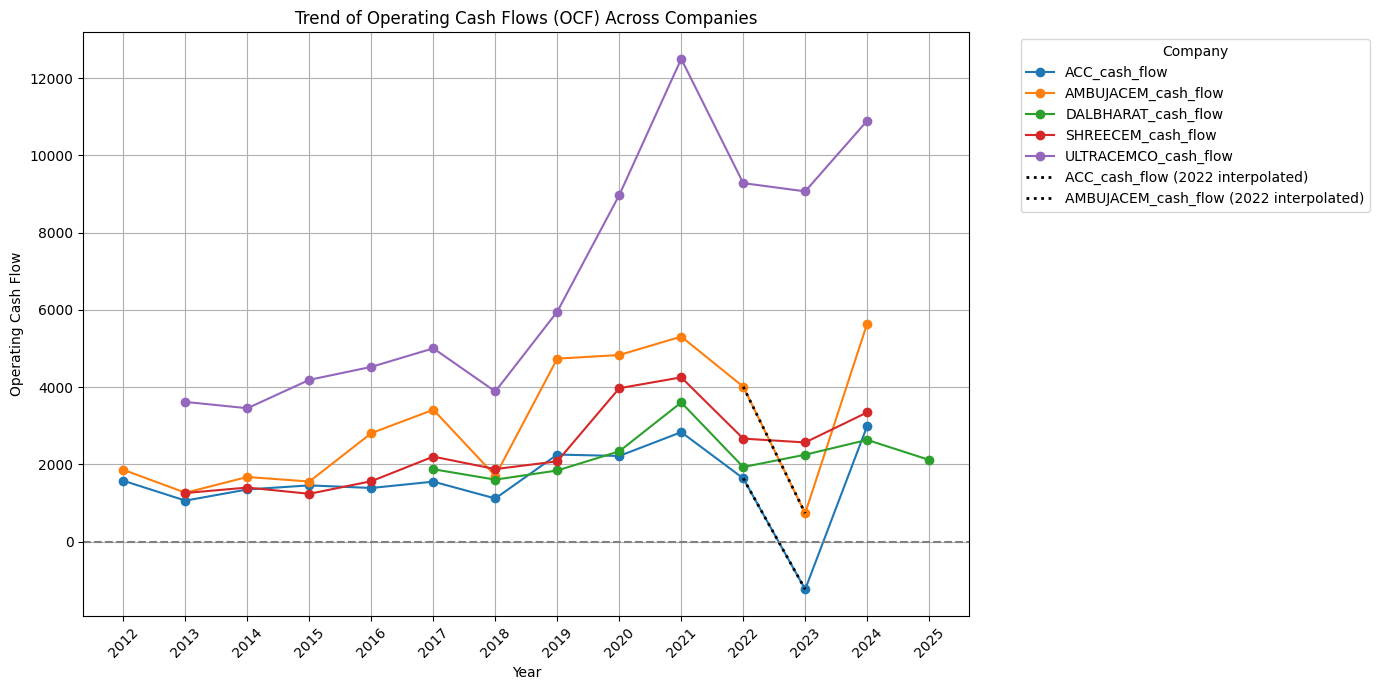

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (adjust path/filename if needed)
df = pd.read_excel(r"C:\Users\KARTHIKA\cement\Cement_Combined_Cashflow_new.xlsx", sheet_name="Combined_Cashflow_new")

# Filter only 'Cash from Operating Activity'
ocf_df = df[df['Financial_Metric'] == 'Cash from Operating Activity'].copy()

# Strip whitespace from column names
ocf_df.columns = [str(col).strip() for col in ocf_df.columns]
ocf_df['Company'] = ocf_df['Company'].str.strip()

# Extract company names
companies = ocf_df['Company'].unique()

# Reshape data
ocf_df = ocf_df.set_index('Company')
ocf_df = ocf_df.drop(columns=['Financial_Metric'])

# Only numeric year columns
year_cols = [col for col in ocf_df.columns if str(col).isdigit()]
ocf_df = ocf_df[year_cols].copy()
ocf_df.columns = ocf_df.columns.astype(int)  # convert columns to int
ocf_df = ocf_df.transpose()  # years as index
ocf_df.index = ocf_df.index.astype(int)

# Plotting
plt.figure(figsize=(14, 7))

# Plot all companies with solid lines
for company in companies:
    plt.plot(ocf_df.index, ocf_df[company], label=company, marker='o')

# Overlay dotted lines from 2022 to 2023 for ACC and AMBUJACEM
highlight_companies = ['ACC_cash_flow', 'AMBUJACEM_cash_flow']
for company in highlight_companies:
    if 2022 in ocf_df.index and 2023 in ocf_df.index:
        x_vals = [2022, 2023]
        y_vals = ocf_df.loc[x_vals, company]
        plt.plot(x_vals, y_vals, linestyle='dotted', linewidth=2, color='black', label=f'{company} (2022 interpolated)')

plt.title('Trend of Operating Cash Flows (OCF) Across Companies')
plt.xlabel('Year')
plt.ylabel('Operating Cash Flow')
plt.grid(True)
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(ocf_df.index, rotation=45)
plt.tight_layout()
plt.show()


3

To identify heavy capital investment periods more accurately, a company-specific 25th percentile threshold was used on investing cash flow data. This evaluates investment levels relative to each company’s own history, avoiding the limitations of a fixed cutoff.

Since firms differ in size and investment patterns, a uniform threshold (e.g., ₹1000 Cr) could miss key trends. The percentile method highlights years of above-normal investment for each company, giving a more meaningful measure of investment intensity.

This approach offers better insight into capital allocation, reinvestment behavior, and the impact on free cash flow.

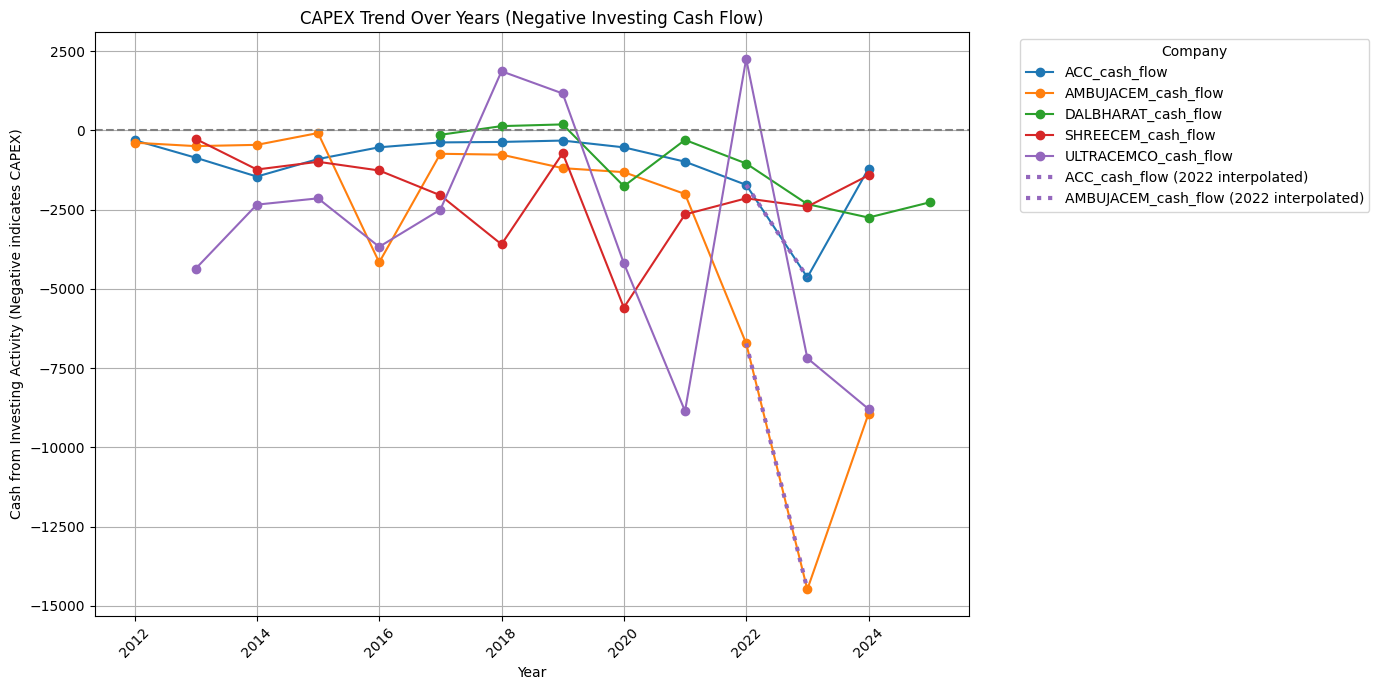

Heavy Capital Investment Years (Company-specific 25th percentile thresholds):
ACC_cash_flow: [2014, 2022, 2023]
AMBUJACEM_cash_flow: [2022, 2023, 2024]
DALBHARAT_cash_flow: [2023, 2024]
SHREECEM_cash_flow: [2018, 2020, 2021]
ULTRACEMCO_cash_flow: [2021, 2023, 2024]


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel(r"C:\Users\KARTHIKA\cement\Cement_Combined_Cashflow_new.xlsx", 
                   sheet_name="Combined_Cashflow_new")

# Filter only 'Cash from Investing Activity' (CAPEX)
capex_df = df[df['Financial_Metric'] == 'Cash from Investing Activity'].copy()

# Set company as index and drop 'Financial_Metric' column
capex_df = capex_df.set_index('Company').drop(columns=['Financial_Metric'])

# Select only numeric year columns
year_cols = [col for col in capex_df.columns if str(col).isdigit()]
capex_df = capex_df[year_cols]

# Transpose so years are rows and companies are columns
capex_df = capex_df.transpose()
capex_df.index = capex_df.index.astype(int)

# -----------------------------
# Plot CAPEX trend (same as before)
plt.figure(figsize=(14, 7))
for company in capex_df.columns:
    plt.plot(capex_df.index, capex_df[company], marker='o', label=company)

highlight_companies = ['ACC_cash_flow', 'AMBUJACEM_cash_flow']
for company in highlight_companies:
    if company in capex_df.columns and 2022 in capex_df.index and 2023 in capex_df.index:
        x_vals = [2022, 2023]
        y_vals = capex_df.loc[x_vals, company]
        plt.plot(x_vals, y_vals, linestyle='dotted', linewidth=3, color=plt.gca().lines[-1].get_color(),label=f'{company} (2022 interpolated)')

plt.title("CAPEX Trend Over Years (Negative Investing Cash Flow)")
plt.xlabel("Year")
plt.ylabel("Cash from Investing Activity (Negative indicates CAPEX)")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.legend(title="Company", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Calculate company-specific thresholds (25th percentile)
company_thresholds = capex_df.quantile(0.25)

# Identify years with heavy investments based on individual thresholds
heavy_investments = {}
for company in capex_df.columns:
    threshold = company_thresholds[company]
    heavy_years = capex_df.index[capex_df[company] < threshold].tolist()
    heavy_investments[company] = heavy_years

# Print result
print("Heavy Capital Investment Years (Company-specific 25th percentile thresholds):")
for comp, years in heavy_investments.items():
    print(f"{comp}: {years if years else 'None'}")

# Save to Excel
heavy_inv_df = pd.DataFrame.from_dict(heavy_investments, orient='index').transpose()
heavy_inv_df.to_excel(r"C:\Users\KARTHIKA\cement\Heavy_CAPEX_Periods_byCompanyThreshold.xlsx", index=False)


5

🔹 Free Cash Flow (FCF):
              ACC     AMBUJACEM    DALBHARAT     SHREECEM    ULTRACEMCO
2012  1885.000000   2248.000000 -2199.699566  -430.204546   8541.795454
2013  1925.000000   1763.000000 -1380.225974  1530.000000   7980.000000
2014  2809.000000   2131.000000  -606.261038  2635.000000   5797.000000
2015  2361.000000   1640.000000   122.195238  2229.000000   6334.000000
2016  1923.000000   6975.000000   805.142857  2831.000000   8199.000000
2017  1933.000000   4154.000000  2014.000000  4250.000000   7506.000000
2018  1482.000000   2468.000000  1471.000000  5474.000000   2022.000000
2019  2576.000000   5930.000000  1654.000000  2800.000000   4791.000000
2020  2754.000000   6149.000000  4100.000000  9563.000000  13164.000000
2021  3823.000000   7316.000000  3904.000000  6905.000000  21356.000000
2022  3359.365707  10734.484411  2977.000000  4811.000000   7026.000000
2023  3402.000000  15216.000000  4578.000000  4974.000000  16257.000000
2024  4200.000000  14587.000000  5385.00

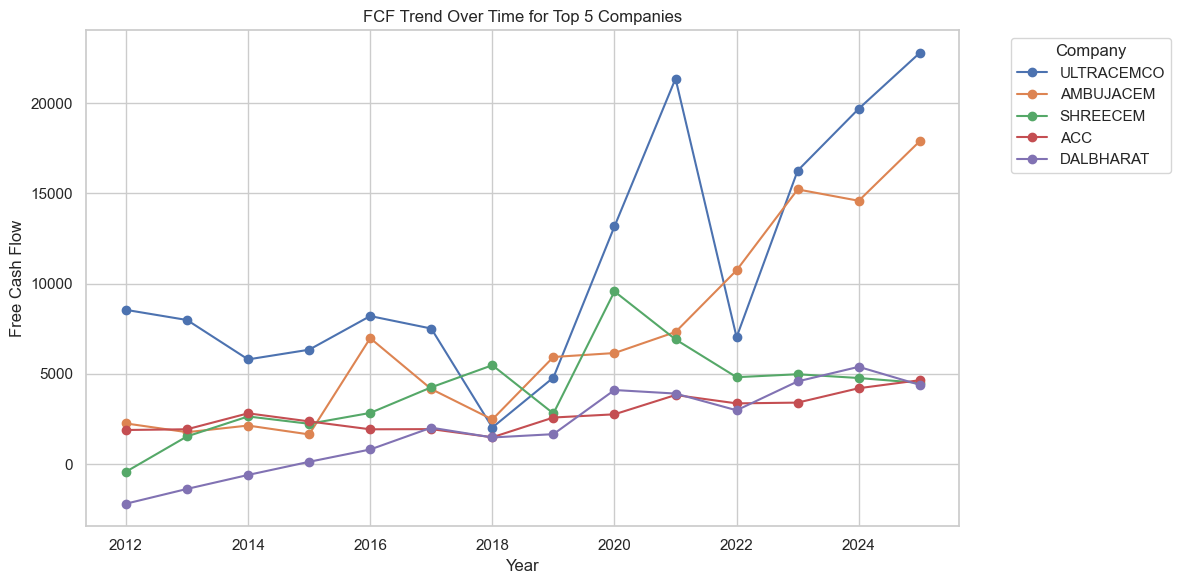

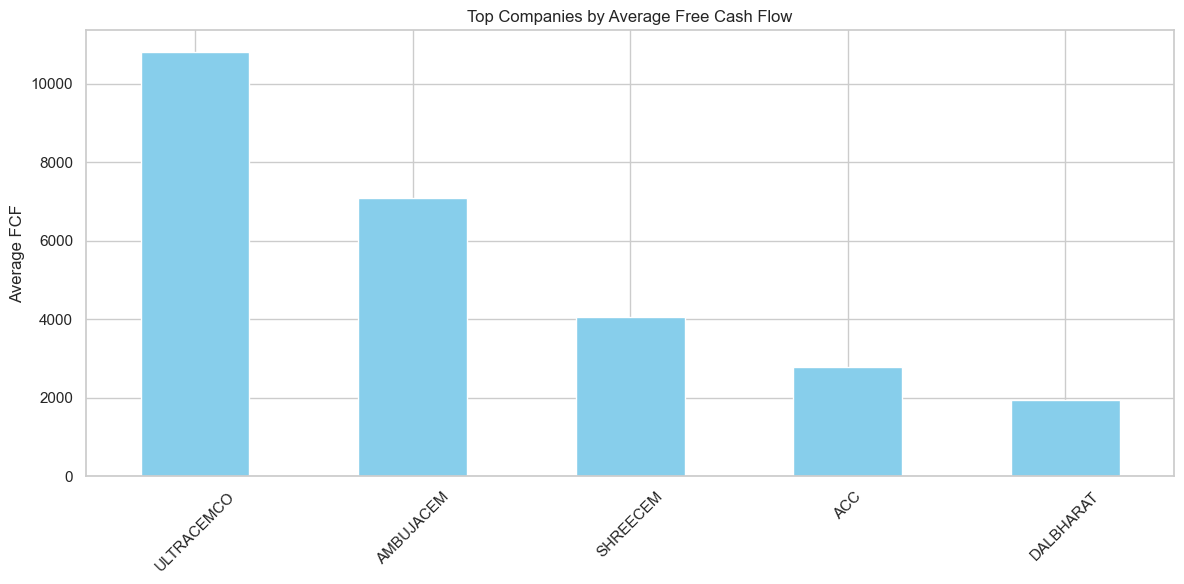

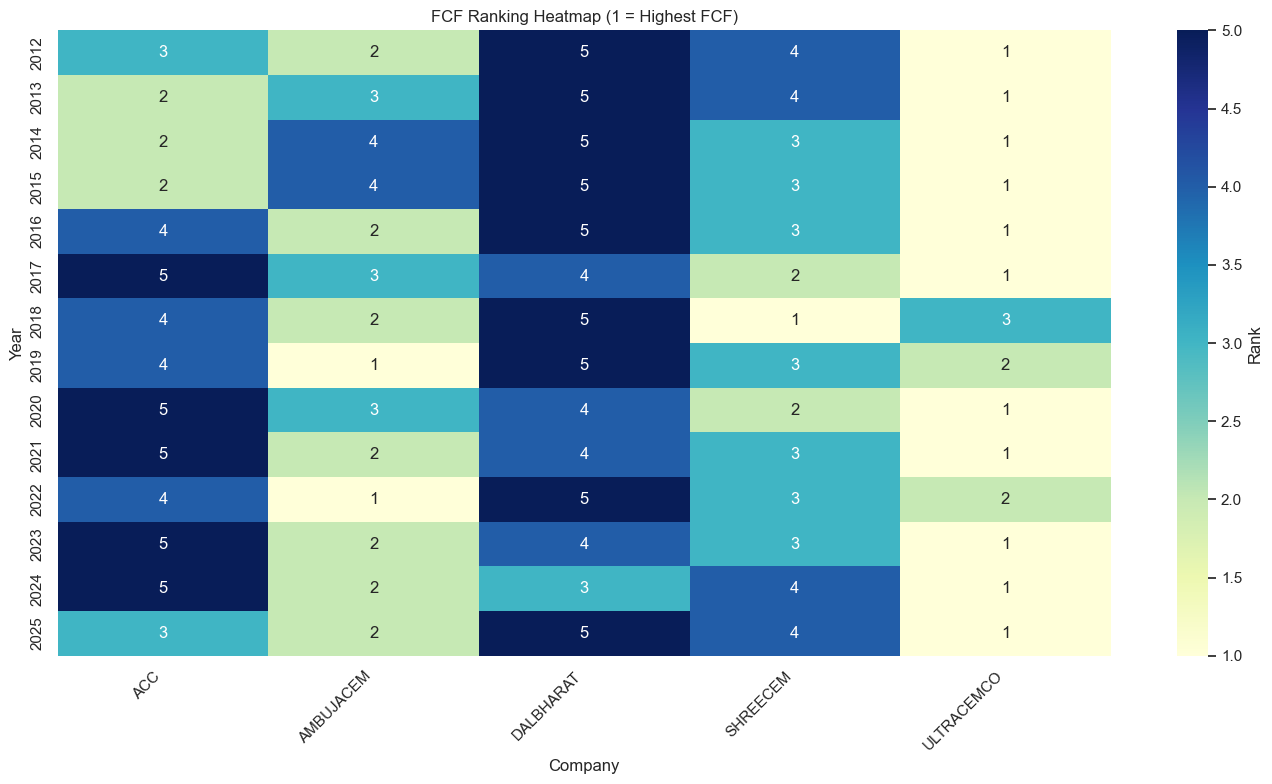

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV or Excel file (replace with your filename if needed)
df = pd.read_excel(r"C:\Users\KARTHIKA\cement\Cement_Combined_Cashflow_new_1.xlsx",
                   sheet_name="Combined_Cashflow_new_1")

# Sample structure based on your pasted format
# Assuming the DataFrame is already loaded in 'df'
# STEP 1: Filter rows for Operating Cash Flow and CAPEX (Investing Activity)
op_cf_df = df[df['Financial_Metric'] == 'Cash from Operating Activity']
capex_df = df[df['Financial_Metric'] == 'Cash from Investing Activity']

# STEP 2: Set Company as index and drop 'Financial_Metric' column
op_cf_df = op_cf_df.drop(columns=['Financial_Metric']).set_index('Company')
capex_df = capex_df.drop(columns=['Financial_Metric']).set_index('Company')

# STEP 3: Convert to numeric (in case of any string values)
op_cf_df = op_cf_df.apply(pd.to_numeric, errors='coerce')
capex_df = capex_df.apply(pd.to_numeric, errors='coerce')

# STEP 4: Transpose for year-wise view (rows: years, columns: companies)
op_cf_df = op_cf_df.transpose()
capex_df = capex_df.transpose()

# STEP 5: Compute FCF = Operating Cash Flow - CAPEX
fcf_df = op_cf_df - capex_df

# STEP 6: Rank companies by FCF for each year (descending)
fcf_rank_df = fcf_df.rank(axis=1, method='min', ascending=False)

# OPTIONAL: Clean column names (remove '_cash_flow' suffix if present)
fcf_df.columns = [col.replace('_cash_flow', '') for col in fcf_df.columns]
fcf_rank_df.columns = fcf_df.columns

# Display results
print("🔹 Free Cash Flow (FCF):")
print(fcf_df)

print("\n🔸 FCF Ranking per Year (1 = highest):")
print(fcf_rank_df)

# OPTIONAL: Average FCF over years
avg_fcf = fcf_df.mean().sort_values(ascending=False)
print("\n⭐ Average FCF over all years:")
print(avg_fcf)

# STEP 9: Export results to Excel
output_path = r"C:\Users\KARTHIKA\cement\FCF_Analysis_Rankings.xlsx"
with pd.ExcelWriter(output_path) as writer:
    fcf_df.to_excel(writer, sheet_name="FCF_Values")
    fcf_rank_df.to_excel(writer, sheet_name="FCF_Rankings")
    avg_fcf.to_excel(writer, sheet_name="Average_FCF")

print("✅ Results saved to Excel file:")
print(output_path)


# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# ➤ 1. Line plot of FCF over time for top 5 companies
top5_companies = avg_fcf.head(5).index
fcf_df[top5_companies].plot(marker='o')
plt.title("FCF Trend Over Time for Top 5 Companies")
plt.xlabel("Year")
plt.ylabel("Free Cash Flow")
plt.legend(title="Company", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(r"C:\Users\KARTHIKA\cement\fcf_top5_trend.png")
plt.show()

# ➤ 2. Bar chart of average FCF by company (top 10)
avg_fcf.head(10).plot(kind='bar', color='skyblue')
plt.title("Top Companies by Average Free Cash Flow")
plt.ylabel("Average FCF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\KARTHIKA\cement\avg_fcf_top10.png")
plt.show()

# ➤ 3. Heatmap of FCF Rankings
plt.figure(figsize=(14, 8))
sns.heatmap(fcf_rank_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Rank'})
plt.title("FCF Ranking Heatmap (1 = Highest FCF)")
plt.ylabel("Year")
plt.xlabel("Company")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(r"C:\Users\KARTHIKA\cement\fcf_rank_heatmap.png")
plt.show()






6

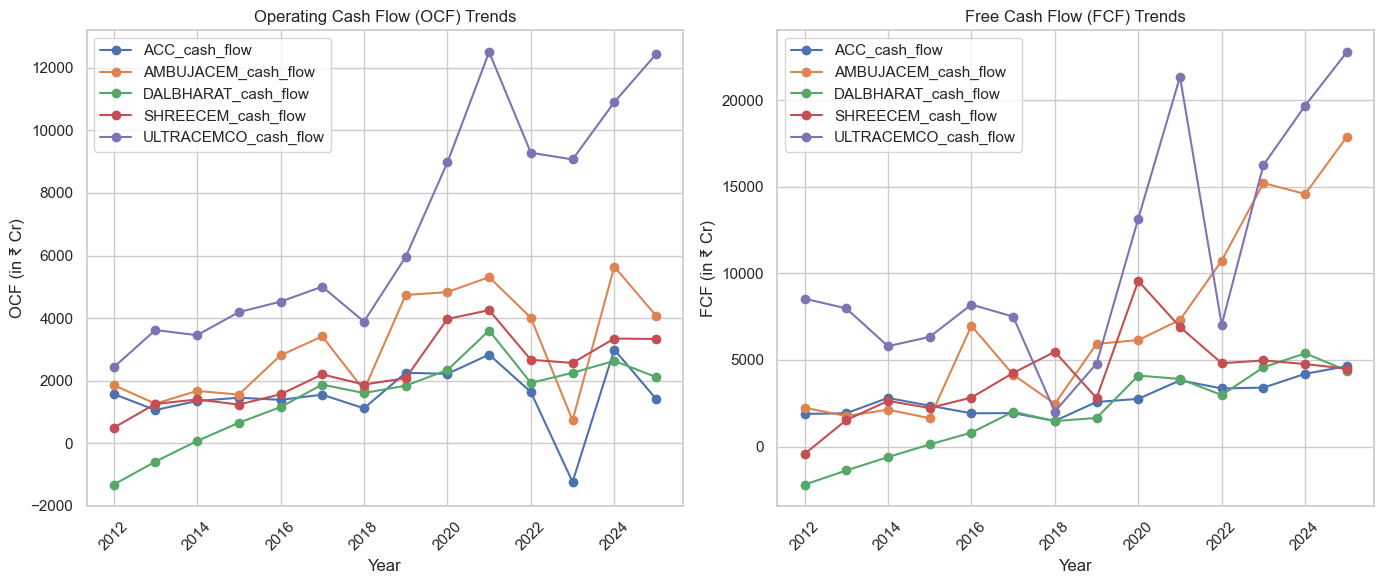

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file (already saved previously)
df = pd.read_excel(r"C:\Users\KARTHIKA\cement\Cement_Combined_Cashflow_new_1.xlsx",
                   sheet_name="Combined_Cashflow_new_1")

# Filter and prepare data
ocf_df = df[df['Financial_Metric'] == 'Cash from Operating Activity'].drop(columns='Financial_Metric').set_index('Company')
capex_df = df[df['Financial_Metric'] == 'Cash from Investing Activity'].drop(columns='Financial_Metric').set_index('Company')

# Convert to numeric
ocf_df = ocf_df.apply(pd.to_numeric, errors='coerce')
capex_df = capex_df.apply(pd.to_numeric, errors='coerce')

# Transpose for year-wise view (years as index)
ocf_df = ocf_df.transpose()
capex_df = capex_df.transpose()

# Calculate FCF
fcf_df = ocf_df - capex_df

# Plotting
plt.figure(figsize=(14, 6))

# Plot OCF
plt.subplot(1, 2, 1)
for company in ocf_df.columns:
    plt.plot(ocf_df.index, ocf_df[company], marker='o', label=company)
plt.title('Operating Cash Flow (OCF) Trends')
plt.xlabel('Year')
plt.ylabel('OCF (in ₹ Cr)')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)

# Plot FCF
plt.subplot(1, 2, 2)
for company in fcf_df.columns:
    plt.plot(fcf_df.index, fcf_df[company], marker='o', label=company)
plt.title('Free Cash Flow (FCF) Trends')
plt.xlabel('Year')
plt.ylabel('FCF (in ₹ Cr)')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()


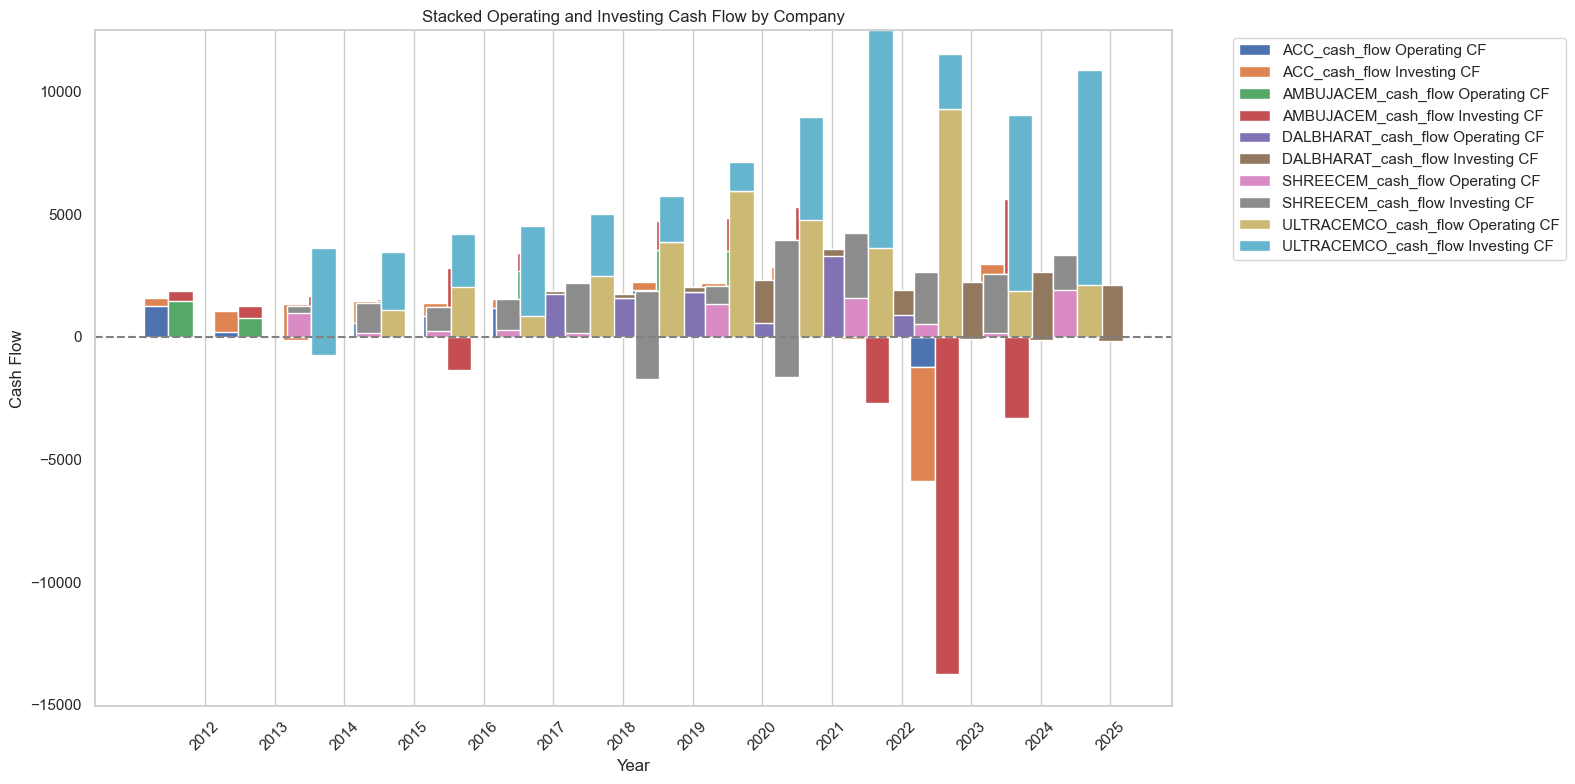

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_excel(r"C:\Users\KARTHIKA\cement\Cement_Combined_Cashflow_new.xlsx", 
                   sheet_name="Combined_Cashflow_new")

# Filter Operating and Investing Cash Flows
ocf_df = df[df['Financial_Metric'] == 'Cash from Operating Activity'].copy()
icf_df = df[df['Financial_Metric'] == 'Cash from Investing Activity'].copy()

# Prepare dataframes
def prepare_df(data):
    data = data.set_index('Company').drop(columns=['Financial_Metric'])
    year_cols = [col for col in data.columns if str(col).isdigit()]
    data = data[year_cols].transpose()
    data.index = data.index.astype(int)
    return data

ocf_df = prepare_df(ocf_df)
icf_df = prepare_df(icf_df)

# Align companies and years
common_years = sorted(set(ocf_df.index) & set(icf_df.index))
common_companies = sorted(set(ocf_df.columns) & set(icf_df.columns))

ocf_df = ocf_df.loc[common_years, common_companies]
icf_df = icf_df.loc[common_years, common_companies]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.35
x = np.arange(len(common_years))
n_companies = len(common_companies)
total_width = n_companies * bar_width

for i, company in enumerate(common_companies):
    pos = x - total_width/2 + i * bar_width + bar_width/2
    ax.bar(pos, ocf_df[company], width=bar_width, label=f'{company} Operating CF')
    ax.bar(pos, icf_df[company], width=bar_width, bottom=ocf_df[company], label=f'{company} Investing CF')

ax.set_xlabel('Year')
ax.set_ylabel('Cash Flow')
ax.set_title('Stacked Operating and Investing Cash Flow by Company')
ax.set_xticks(x)
ax.set_xticklabels(common_years, rotation=45)
ax.axhline(0, color='gray', linestyle='--')
ax.grid(axis='y')

# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
